# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: **fine-tuning**.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during training to better suit your own data.

For **feature extraction transfer learning**, you may only train the top 1-3 layers of a pre-trained model with your own data, in **fine-tuning transfer learning**, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API `tf.keras.Model`, a different way to build models in Keras (difference explain later in this notebook)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [1]:
import random 
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Mon Nov  7 12:08:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import unzip_data, walk_through_dir

--2022-11-07 12:08:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-07 12:08:54 (98.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = 1 if n<=3 else n//2
    col = n if n<=3 else n//2 + n%2

    plt.figure(figsize=(5*(col+1) + zoom , 5*row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col+1, i+1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2) # padding
    
    plt.subplot(row, col+1, n+1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = Path().cwd() / dir_name / experiment_name / datetime.datetime.now().strftime("%d-%b-%Y_%H:%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  return tensorboard_callback

In [6]:
import matplotlib.image as mpimg

def plot_image(list_im_path, i, data_augmentation=None):

    im = mpimg.imread(list_im_path[i])/255

    if data_augmentation is not None :
        im = data_augmentation(im, training=True)

    plt.imshow(im)
    plt.axis(False)

## Getting data ready

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [7]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-11-07 12:08:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.8MB/s    in 7.8s    

2022-11-07 12:09:02 (20.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [9]:
from pathlib import Path

train_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "train"
test_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "test"

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_set_10_percent = image_dataset_from_directory(train_dir_10_percent, label_mode="categorical", image_size=(224,224)) 
test_set_10_percent = image_dataset_from_directory(test_dir_10_percent, label_mode="categorical", image_size=(224,224)) 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_set_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example batch of data

for images, labels in train_set_10_percent.take(1):
    print(np.max(images), np.min(images), labels[:5])

255.0 0.0 tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


### Model 0: Building a transfer learning model using the Keras Functional API

We're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.  
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
![](https://www.researchgate.net/publication/338079465/figure/fig4/AS:905983672987648@1593014748012/The-difference-of-max-pooling-and-global-max-pooling.ppm)
**GlobalMaxPooling2D explain after**

7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).


In [13]:
tf.random.set_seed(0)

base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we will put our own top layers
base_model.trainable = False

inputs = tf.keras.Input((224, 224, 3), name="input_layer")

# x = preprocessing(inputs) # WARING : dont Rescaling with EfficientNetB0
x = base_model(inputs) # `x` insteed of `inputs` if `x = preprocessing(inputs)` not commented
print(x.shape)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
print(x.shape)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")
outputs = outputs(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["acc"])

16705208/16705208 [==============================] - 2s 0us/step
(None, 7, 7, 1280)
(None, 1280)


<font size="6">
What is the difference between `tf.keras.Model` and `tf.keras.Sequential` ?
</font>

An Sequential model is the simplest type of model, a linear stack of layers. But it's limited in certain points. We can't build complex networks such as multi-input or multi-output networks using this API.

Using **`tf.keras.Model`** API, allow more flexibility and **easily define models where each layer can connect not just with the previous and next layers but also share feature information with other layers in the model**, for example, model-like ResNet, EfficientNet.

In [14]:
callback_0 = create_tensorboard_callback("transfer_learning", "model_0")

history_0 = model_0.fit(train_set_10_percent, 
                        epochs=5,
                        validation_data=test_set_10_percent,
                        callbacks=[callback_0])

Epoch 1/5
24/24 [==============================] - 25s 482ms/step - loss: 4.4334 - acc: 0.1947 - val_loss: 2.2941 - val_acc: 0.4288
Epoch 2/5
24/24 [==============================] - 8s 329ms/step - loss: 1.4993 - acc: 0.5760 - val_loss: 1.3703 - val_acc: 0.6240
Epoch 3/5
24/24 [==============================] - 8s 329ms/step - loss: 0.9766 - acc: 0.7160 - val_loss: 1.1936 - val_acc: 0.6732
Epoch 4/5
24/24 [==============================] - 8s 338ms/step - loss: 0.6757 - acc: 0.7773 - val_loss: 1.2158 - val_acc: 0.6692
Epoch 5/5
24/24 [==============================] - 8s 332ms/step - loss: 0.5482 - acc: 0.8267 - val_loss: 1.0396 - val_acc: 0.7172


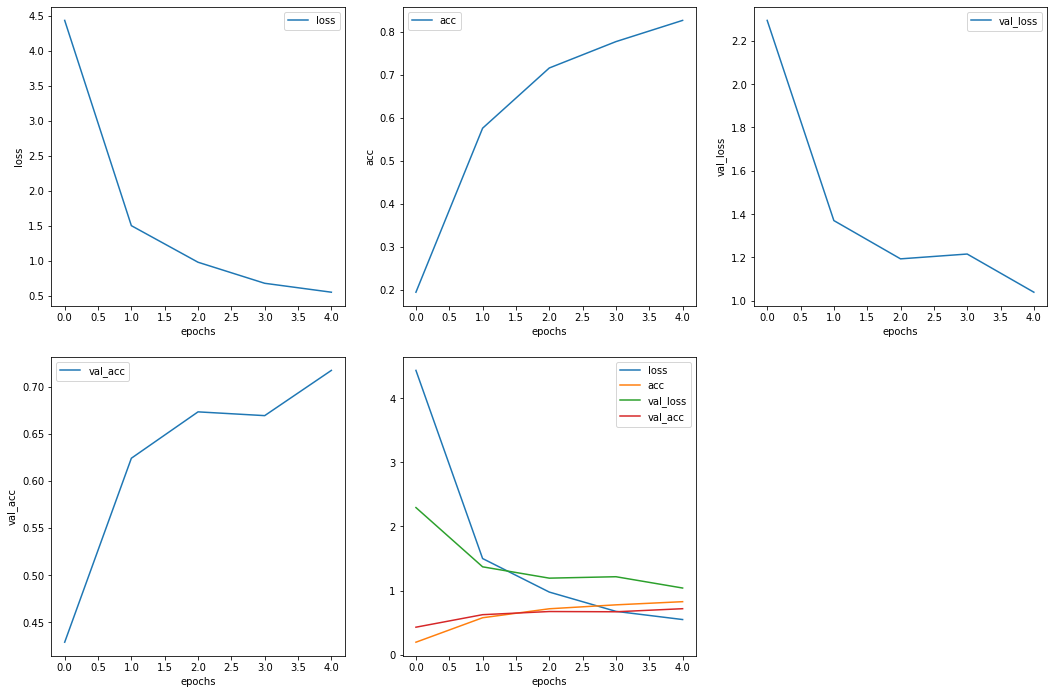

In [15]:
plot_history(history_0)

In [16]:
score_0 = model_0.evaluate(test_set_10_percent)

79/79 [==============================] - 6s 74ms/step - loss: 1.0396 - acc: 0.7172


In [17]:
# Check layers in our base model
for i, layer in enumerate(model_0.layers):
  print(i, layer.name)

0 input_layer
1 efficientnetb0
2 global_max_pooling2d
3 output_layer


## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [18]:
input_shape = (1, 2, 4, 3) # axis => 0, 1, 2, 3

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global max pooled input tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]]]

2D global max pooled random tensor:
 [[0.9058464 0.539707  1.6994323]]

Shape of input tensor: (1, 2, 4, 3)
Shape of 2D global max pooled input tensor: (1, 3)


In [19]:
tf.reduce_max(input_tensor, axis=[1, 2]).numpy()

array([[0.9058464, 0.539707 , 1.6994323]], dtype=float32)

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note 1 :** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D). layer) which can then be used to extract patterns out of.

> 🔑 **Note 2 :** We can also use `tf.kersa.layers.Flatten()` and `tf.keras.layers.MaxPooling2D()`.

In [20]:
max_pooled_tensor = tf.keras.layers.MaxPooling2D()(input_tensor)
max_pooled_flatten = tf.keras.layers.Flatten()(max_pooled_tensor)
max_pooled_flatten.numpy()

array([[ 0.8504023 , -0.40604794,  0.3194337 ,  0.9058464 ,  0.539707  ,
         1.6994323 ]], dtype=float32)

In [21]:
max_pooled_tensor.numpy()

array([[[[ 0.8504023 , -0.40604794,  0.3194337 ],
         [ 0.9058464 ,  0.539707  ,  1.6994323 ]]]], dtype=float32)

## Running a series of transfer learning experiments

Experiments:

0. `model_0_bis` : Use [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) insteed of [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en)
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

### **Model 0 bis**

In [22]:
tf.random.set_seed(0)

inputs = tf.keras.Input((224,224,3), name="input_layer")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_2D")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="outputs")(x)

model_0_bis = tf.keras.Model(inputs, outputs)

model_0_bis.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["acc"])

In [23]:
callback_0_bis = create_tensorboard_callback("transfer_learning", "model_0_bis")

history_0_bis = model_0_bis.fit(train_set_10_percent,
                                epochs=5,
                                validation_data=test_set_10_percent,
                                callbacks=[callback_0_bis])

Epoch 1/5
24/24 [==============================] - 16s 400ms/step - loss: 1.8939 - acc: 0.4160 - val_loss: 1.3176 - val_acc: 0.7240
Epoch 2/5
24/24 [==============================] - 8s 334ms/step - loss: 1.0976 - acc: 0.7680 - val_loss: 0.8707 - val_acc: 0.8252
Epoch 3/5
24/24 [==============================] - 8s 331ms/step - loss: 0.7919 - acc: 0.8240 - val_loss: 0.6988 - val_acc: 0.8448
Epoch 4/5
24/24 [==============================] - 8s 332ms/step - loss: 0.6400 - acc: 0.8680 - val_loss: 0.6098 - val_acc: 0.8524
Epoch 5/5
24/24 [==============================] - 8s 332ms/step - loss: 0.5326 - acc: 0.8933 - val_loss: 0.5558 - val_acc: 0.8592


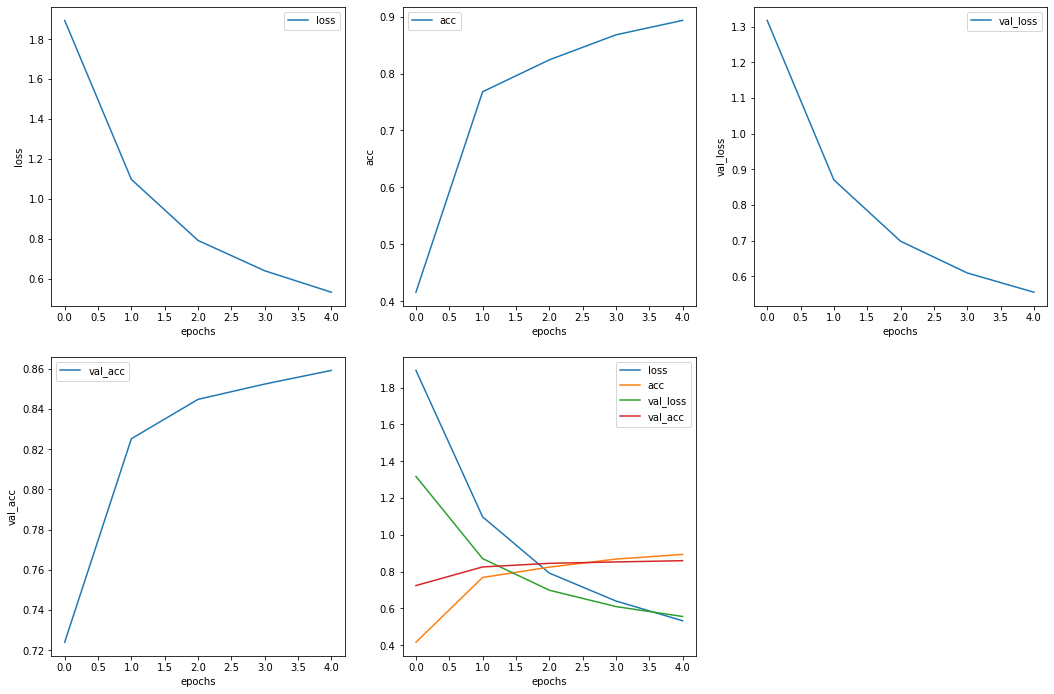

In [24]:
plot_history(history_0_bis)

In [25]:
score_0_bis = model_0_bis.evaluate(test_set_10_percent)

79/79 [==============================] - 6s 75ms/step - loss: 0.5558 - acc: 0.8592


#### comparing

In [26]:
scores = [
    ["model_0", score_0[1]],
    ["model_0_bis", score_0_bis[1]]
]

pd.DataFrame(scores, columns=["model", "test score"])

,model,test score
0,model_0,0.7172
1,model_0_bis,0.8592


Base model will be this one

### **Model 1**
**`model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.**

In [27]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

train_dir_1_percent = Path.cwd() / "10_food_classes_1_percent" / "train"
test_dir_1_percent = Path.cwd() / "10_food_classes_1_percent" / "test"

--2022-11-07 12:11:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.0MB/s    in 6.4s    

2022-11-07 12:11:34 (19.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [28]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_set_1_percent = image_dataset_from_directory(train_dir_1_percent, label_mode="categorical", image_size=(224,224)) 
test_set_1_percent = image_dataset_from_directory(test_dir_1_percent, label_mode="categorical", image_size=(224,224))

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could: **The key benefit to doing this is that it makes your model portable**

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> **Note:** [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation) and [TensorFlow preprocessing guide](https://www.tensorflow.org/guide/keras/preprocessing_layers)

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis during training.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount during training.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount during training.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts (or varies) image height by a specified amount during training.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts (or varies) image width by a specified amount during training.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

<br><br>

---

<font size="4">
<strong>issue of images not augmenting</strong> : <br>
A fix should be on the way from the TensorFlow team but for now, one way to fix it is to make sure the parameter training=True is passed to a data augmentation model.
<br><br>
This is because data augmentation is only intended to work during training and not testing.
<br><br>
Code after the fix
</font>

```
augmented_img = data_augmentation(img, training=True)
```

---

<br><br>

In [29]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1./255), # keep for ResNet50V2, remove for EfficientNetB0
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
    tf.keras.layers.RandomZoom((-0.2,-0.2), fill_mode="constant"), # A positive value means zooming out, while a negative value means zooming in
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
    ], 
    name="data_augmentation")

In [30]:
classe = random.choice(train_set_1_percent.class_names)
im_path = Path.cwd() / "10_food_classes_1_percent" / "train" / classe
list_im_path = [path for path in im_path.glob("*")]

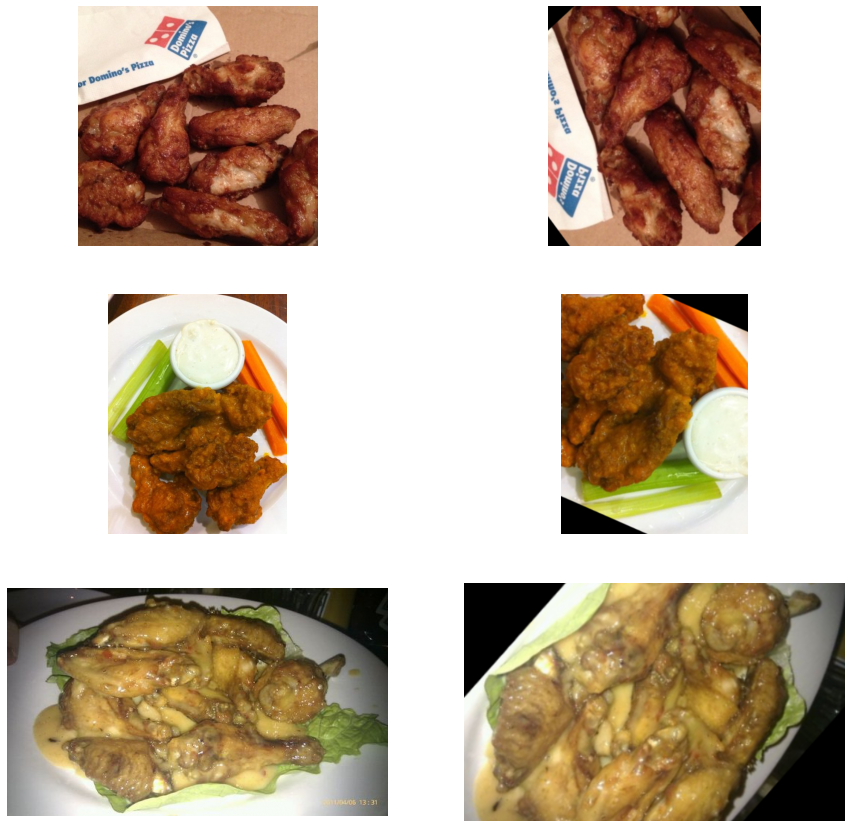

In [31]:
plt.figure(figsize=(15,15))
for i in range(0, 3):
    plt.subplot(3,2,2*i+1)
    plot_image(list_im_path, i) # data_augmentation(im, training=True)

    plt.subplot(3,2,2*i+2)
    plot_image(list_im_path, i, data_augmentation) # data_augmentation(im, training=True)

#### Model 1: 
**Feature extraction transfer learning on 1% of the data with data augmentation**

In [32]:
tf.random.set_seed(0)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="sigmoid", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["acc"])

In [33]:
callbacks_1 = create_tensorboard_callback("transfer_learning", "model_1")

history_1 = model_1.fit(train_set_1_percent,
                        epochs=10,
                        validation_data=test_set_1_percent,
                        callbacks=[callbacks_1])

Epoch 1/10


3/3 [==============================] - ETA: 0s - loss: 2.3607 - acc: 0.1143

3/3 [==============================] - 15s 4s/step - loss: 2.3607 - acc: 0.1143 - val_loss: 2.2676 - val_acc: 0.1668
Epoch 2/10
3/3 [==============================] - 8s 4s/step - loss: 2.1323 - acc: 0.2714 - val_loss: 2.1398 - val_acc: 0.2408
Epoch 3/10
3/3 [==============================] - 8s 3s/step - loss: 1.9027 - acc: 0.4571 - val_loss: 2.0213 - val_acc: 0.3268
Epoch 4/10
3/3 [==============================] - 7s 3s/step - loss: 1.7554 - acc: 0.6000 - val_loss: 1.9133 - val_acc: 0.4060
Epoch 5/10
3/3 [==============================] - 7s 3s/step - loss: 1.5570 - acc: 0.7000 - val_loss: 1.8188 - val_acc: 0.4576
Epoch 6/10
3/3 [==============================] - 11s 6s/step - loss: 1.4720 - acc: 0.7857 - val_loss: 1.7297 - val_acc: 0.5056
Epoch 7/10
3/3 [==============================] - 7s 3s/step - loss: 1.3184 - acc: 0.8143 - val_loss: 1.6487 - val_acc: 0.5488
Epoch 8/10
3/3 [==============================] - 7s 3s/step - loss: 1.1135 - acc: 0.8857 - val_loss: 1.5766 - val_acc: 

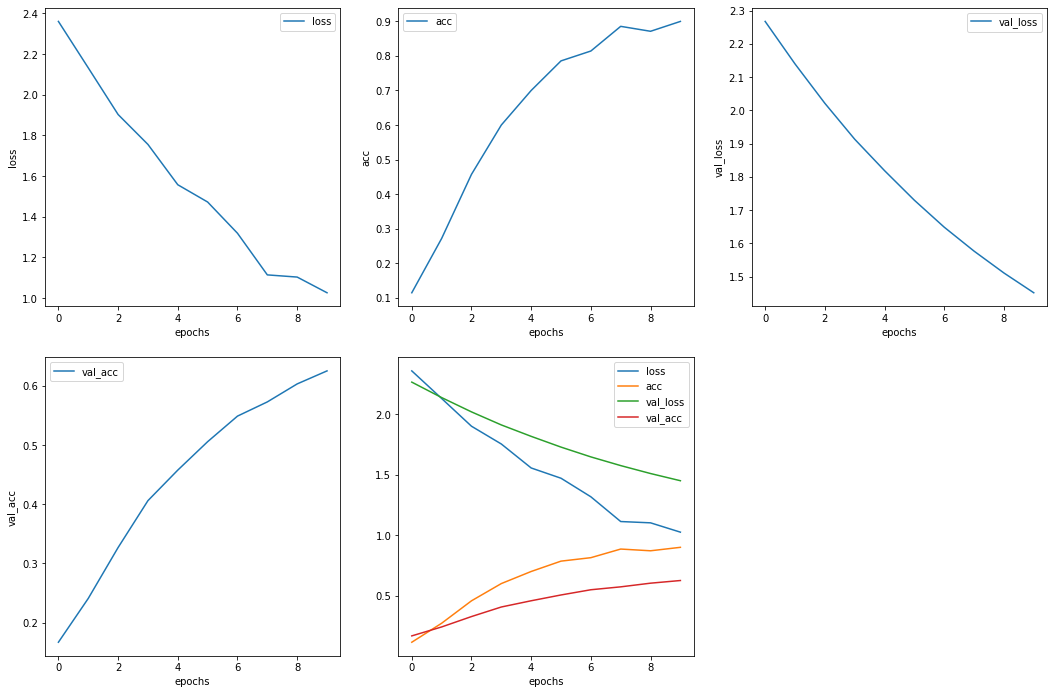

In [34]:
plot_history(history_1)

In [35]:
score_1 = model_1.evaluate(test_set_1_percent)

79/79 [==============================] - 6s 75ms/step - loss: 1.4514 - acc: 0.6252


## Model 2
**`model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.**

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [113]:
tf.random.set_seed(0)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="sigmoid", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["acc"])

In [114]:
len(model_2.trainable_variables) # Global_Average_Pooling_layer and output_layer

2

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the **[`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights)** to a specified directory as it trains.

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

> The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do. 

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [115]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                           save_weights_only=True, # set to False to save the entire model
                                                           save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                           save_freq="epoch", # save every epoch
                                                           verbose=1)

In [116]:
callback_2 = create_tensorboard_callback("transfer_learning", "model_2")

init_epochs = 10
history_2 = model_2.fit(train_set_10_percent, 
                        epochs=init_epochs,
                        validation_data=test_set_10_percent,
                        callbacks=[callback_2, checkpoint_callback_2])

Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 1.9935 - acc: 0.3413


Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 457ms/step - loss: 1.9935 - acc: 0.3413 - val_loss: 1.4623 - val_acc: 0.6572
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3302 - acc: 0.6893
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 407ms/step - loss: 1.3302 - acc: 0.6893 - val_loss: 1.0090 - val_acc: 0.7916
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0042 - acc: 0.7680
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 401ms/step - loss: 1.0042 - acc: 0.7680 - val_loss: 0.8094 - val_acc: 0.8232
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8516 - acc: 0.7920
Epoch 4: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 384ms/

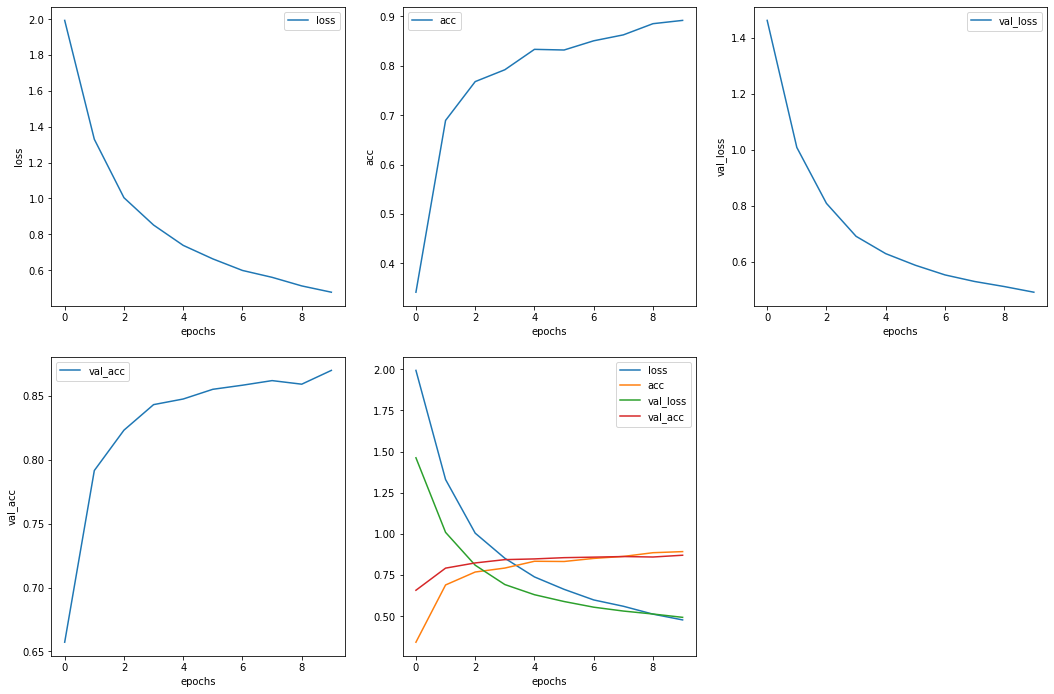

In [117]:
plot_history(history_2)

In [41]:
score_2 = model_2.evaluate(test_set_10_percent)

79/79 [==============================] - 6s 75ms/step - loss: 0.4952 - acc: 0.8648


In [42]:
scores = [
    ["model_2", score_2[1]],
    ["model_0_bis", score_0_bis[1]]
]

pd.DataFrame(scores, columns=["model", "test score"]) # score less but no overfitting

,model,test score
0,model_2,0.8648
1,model_0_bis,0.8592


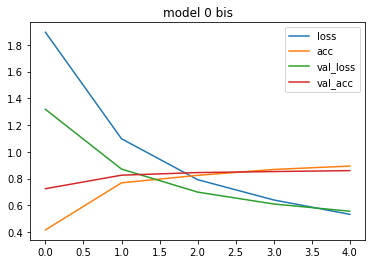

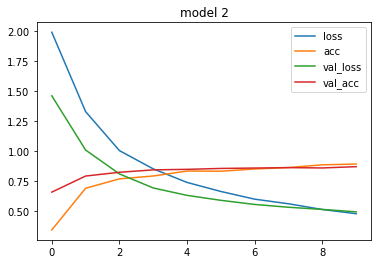

In [118]:
pd.DataFrame(history_0_bis.history).plot(figsize=None)
plt.title("model 0 bis") # overfitting

pd.DataFrame(history_2.history).plot(figsize=None)
plt.title("model 2"); # no overfitting

Since we checkpointed our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [44]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
score_2_loaded = model_2.evaluate(test_set_10_percent) # same as befor

79/79 [==============================] - 6s 76ms/step - loss: 0.4952 - acc: 0.8648


In [45]:
score_2 == score_2_loaded

False

In [46]:
# if cell above is False, they may be a issue with the precision :
np.isclose(score_2, score_2_loaded)

array([ True,  True])

## Model 3: Fine-tuning an existing model (model_2) on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using **feature extraction transfer learning** for 10 epochs on 10% of the training data and data augmentation.<br>
This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to **fine-tuning transfer learning**. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).
*texte en italique*
We've verified our loaded model's performance, let's check out its layers.

In [47]:
model_2.layers

In [48]:
for layer in model_2.layers:
    print(layer.trainable)

True
True
False
True
True


In [49]:
print(len(model_2.layers[2].trainable_variables))

0


In [50]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [51]:
for i, layer in enumerate(base_model.layers):
    print(f"{i:<3} {layer.name:-<30} {layer.trainable}")

0   input_4----------------------- False
1   rescaling_3------------------- False
2   normalization_3--------------- False
3   tf.math.truediv_3------------- False
4   stem_conv_pad----------------- False
5   stem_conv--------------------- False
6   stem_bn----------------------- False
7   stem_activation--------------- False
8   block1a_dwconv---------------- False
9   block1a_bn-------------------- False
10  block1a_activation------------ False
11  block1a_se_squeeze------------ False
12  block1a_se_reshape------------ False
13  block1a_se_reduce------------- False
14  block1a_se_expand------------- False
15  block1a_se_excite------------- False
16  block1a_project_conv---------- False
17  block1a_project_bn------------ False
18  block2a_expand_conv----------- False
19  block2a_expand_bn------------- False
20  block2a_expand_activation----- False
21  block2a_dwconv_pad------------ False
22  block2a_dwconv---------------- False
23  block2a_bn-------------------- False
24  block2a_acti

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

In [52]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

> **NOTE** : 
```
for layer in base_model.layers[-10:]:
    layer.trainable = True
```
**DOESN'T WORK**

In [53]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["acc"])

In [54]:
len(model_2.trainable_variables) 

12

In [55]:
print(len(model_2.layers[2].trainable_variables))

10


> 🤔 **Question:** Why did we recompile the model ? <br><br>
Every time you make a change to your models, you need to recompile them.

We also change the `learning_rate` from $0.001$ to $0.0001$
<br>
**We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.**

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

### Time to **fine-tune**

We're going to continue training on from where our previous model finished. Since it trained for 10 epochs, our fine-tuning will begin on the epoch 10 and continue for another 5 epochs.

To do this, we can use the `init_epoch` parameter of the [`fit()`](https://keras.rstudio.com/reference/fit.html) method. We'll pass it the last epoch of the previous model's training history (`history_2.epoch[-1]`).

In [56]:
callback_2_fine_tune = create_tensorboard_callback("transfer_learning", "model_2_fine_tune")

fine_tune_epochs = init_epochs + 5

history_2_fine_tune = model_2.fit(train_set_10_percent,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_set_10_percent,
                                  initial_epoch=history_2.epoch[-1],
                                  callbacks=[callback_2_fine_tune])

Epoch 10/15


24/24 [==============================] - ETA: 0s - loss: 0.4427 - acc: 0.8720

24/24 [==============================] - 23s 620ms/step - loss: 0.4427 - acc: 0.8720 - val_loss: 0.4236 - val_acc: 0.8700
Epoch 11/15
24/24 [==============================] - 12s 508ms/step - loss: 0.3379 - acc: 0.9107 - val_loss: 0.4294 - val_acc: 0.8624
Epoch 12/15
24/24 [==============================] - 13s 546ms/step - loss: 0.2937 - acc: 0.9147 - val_loss: 0.4112 - val_acc: 0.8688
Epoch 13/15
24/24 [==============================] - 12s 505ms/step - loss: 0.2869 - acc: 0.9187 - val_loss: 0.3992 - val_acc: 0.8696
Epoch 14/15
24/24 [==============================] - 12s 499ms/step - loss: 0.2595 - acc: 0.9213 - val_loss: 0.4077 - val_acc: 0.8680
Epoch 15/15
24/24 [==============================] - 12s 488ms/step - loss: 0.2168 - acc: 0.9453 - val_loss: 0.4029 - val_acc: 0.8692


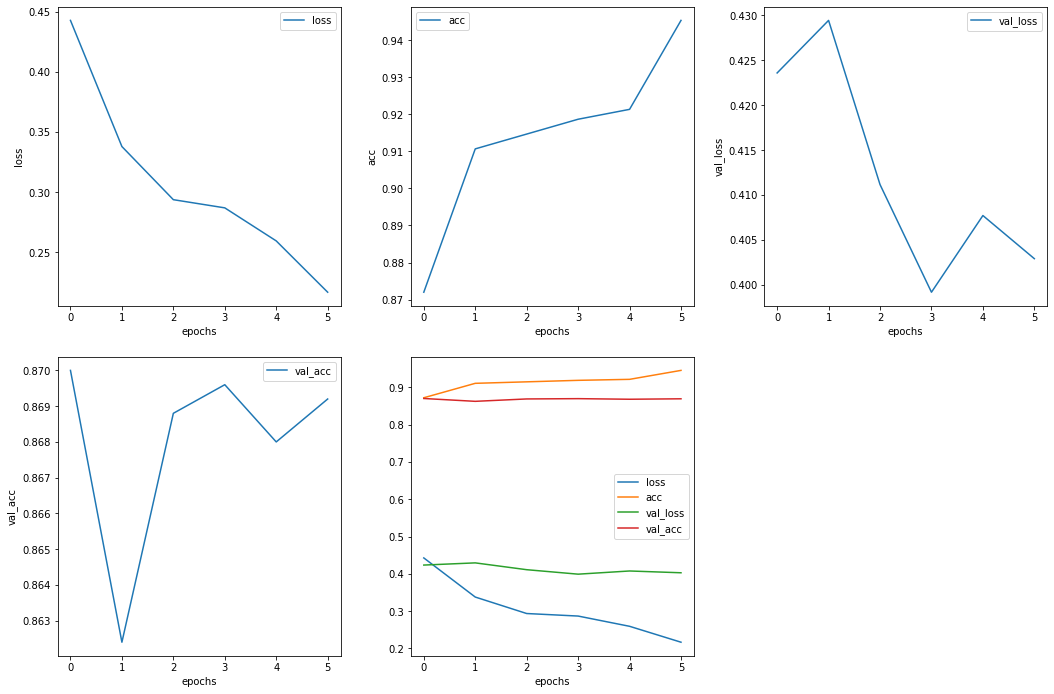

In [57]:
plot_history(history_2_fine_tune)

In [58]:
score_2_fine_tune = model_2.evaluate(test_set_10_percent)

79/79 [==============================] - 6s 74ms/step - loss: 0.4029 - acc: 0.8692


### Comparing

In [84]:
def compare_historys(original_history, new_history, initial_epochs=5):

    # Get original history measurements
    acc = original_history.history["acc"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_acc"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["acc"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_acc"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

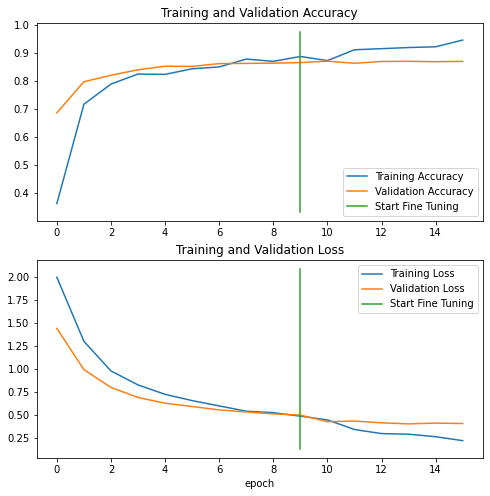

In [85]:
compare_historys(original_history=history_2, 
                 new_history=history_2_fine_tune, 
                 initial_epochs=10)

Not so good, let's try with more data

## Model 4: Fine-tuning an existing model (model_2) all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.

In [61]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-11-07 12:18:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  21.8MB/s    in 22s     

2022-11-07 12:18:48 (22.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [62]:
IMG_SIZE = (224, 224)
train_set = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [63]:
model_2.evaluate(test_set)

79/79 [==============================] - 6s 75ms/step - loss: 0.4029 - acc: 0.8692


[0.4029211401939392, 0.8691999912261963]

In [64]:
score_2_fine_tune

[0.4029211103916168, 0.8691999912261963]

In [86]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [87]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_set)

79/79 [==============================] - 7s 77ms/step - loss: 0.4952 - accuracy: 0.8648


[0.49517789483070374, 0.864799976348877]

In [88]:
score_2

[0.4951777756214142, 0.864799976348877]

Alright, the previous steps might seem quite confusing but all we've done is:
1. **step_1** : Trained a feature extraction transfer learning model for 10 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. **step_2** :Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. **step_3** :Saved the results and training logs each time.
4. **step_4** :Reloaded the model from step_1 to do the same steps as step_2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [89]:
# Check which layers are tuneable in the whole model
for i, layer in enumerate(model_2.layers):
    print(f"{i:<3} {layer.name:-<30} {layer.trainable}")

0   input_layer------------------- True
1   data_augmentation------------- True
2   efficientnetb0---------------- True
3   Global_Average_Pooling_layer-- True
4   output_layer------------------ True


In [90]:
i = 236 - 15 + 1
for layer in base_model.layers[-15:]:
    print(f"{i:<3} {layer.name:-<30} {layer.trainable}")
    i += 1

222 block7a_expand_bn------------- False
223 block7a_expand_activation----- False
224 block7a_dwconv---------------- False
225 block7a_bn-------------------- False
226 block7a_activation------------ False
227 block7a_se_squeeze------------ True
228 block7a_se_reshape------------ True
229 block7a_se_reduce------------- True
230 block7a_se_expand------------- True
231 block7a_se_excite------------- True
232 block7a_project_conv---------- True
233 block7a_project_bn------------ True
234 top_conv---------------------- True
235 top_bn------------------------ True
236 top_activation---------------- True


In [91]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["acc"])

In [92]:
callback_2_fine_tune_full_data = create_tensorboard_callback("transfer_learning", "model_2_fine_tune_full_data")

fine_tune_epochs = init_epochs + 5

history_2_fine_tune_full_data = model_2.fit(train_set,
                                            epochs=fine_tune_epochs,
                                            initial_epoch=history_2.epoch[-1],
                                            validation_data=test_set,
                                            callbacks=[callback_2_fine_tune_full_data])

Epoch 10/15


235/235 [==============================] - ETA: 0s - loss: 0.6069 - acc: 0.8044

235/235 [==============================] - 54s 201ms/step - loss: 0.6069 - acc: 0.8044 - val_loss: 0.3317 - val_acc: 0.9008
Epoch 11/15
235/235 [==============================] - 46s 194ms/step - loss: 0.5026 - acc: 0.8373 - val_loss: 0.3078 - val_acc: 0.9028
Epoch 12/15
235/235 [==============================] - 44s 186ms/step - loss: 0.4387 - acc: 0.8596 - val_loss: 0.3002 - val_acc: 0.9000
Epoch 13/15
235/235 [==============================] - 44s 186ms/step - loss: 0.3977 - acc: 0.8751 - val_loss: 0.3031 - val_acc: 0.8988
Epoch 14/15
235/235 [==============================] - 41s 175ms/step - loss: 0.3623 - acc: 0.8864 - val_loss: 0.2938 - val_acc: 0.9016
Epoch 15/15
235/235 [==============================] - 42s 178ms/step - loss: 0.3280 - acc: 0.8916 - val_loss: 0.2742 - val_acc: 0.9056


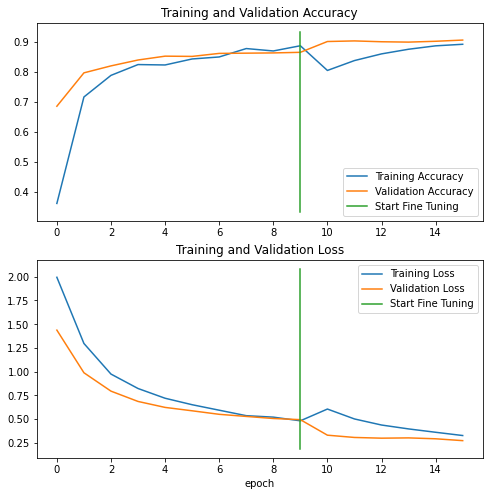

In [93]:
compare_historys(original_history=history_2, 
                 new_history=history_2_fine_tune_full_data, 
                 initial_epochs=10)

In [94]:
score_2_fine_tune_full_data = model_2.evaluate(test_set)

79/79 [==============================] - 7s 77ms/step - loss: 0.2742 - acc: 0.9056


### Comparing with and without fine-tuning

#### Train for 5 more epochs without fine-tuning

In [102]:
model_2.load_weights(checkpoint_path)

In [104]:
base_model.trainable = False

In [105]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["acc"])

In [106]:
# Check which layers are tuneable in the whole model
for i, layer in enumerate(model_2.layers):
    print(f"{i:<3} {layer.name:-<30} {layer.trainable}")

0   input_layer------------------- True
1   data_augmentation------------- True
2   efficientnetb0---------------- False
3   Global_Average_Pooling_layer-- True
4   output_layer------------------ True


In [107]:
history_2_no_fine_tune = model_2.fit(train_set,
                                     epochs=fine_tune_epochs,
                                     initial_epoch=history_2.epoch[-1],
                                     validation_data=test_set
                                     )

Epoch 10/15


235/235 [==============================] - ETA: 0s - loss: 0.6998 - acc: 0.7887

235/235 [==============================] - 48s 176ms/step - loss: 0.6998 - acc: 0.7887 - val_loss: 0.4608 - val_acc: 0.8760
Epoch 11/15
235/235 [==============================] - 41s 172ms/step - loss: 0.6694 - acc: 0.7984 - val_loss: 0.4410 - val_acc: 0.8816
Epoch 12/15
235/235 [==============================] - 40s 169ms/step - loss: 0.6533 - acc: 0.8012 - val_loss: 0.4238 - val_acc: 0.8876
Epoch 13/15
235/235 [==============================] - 39s 166ms/step - loss: 0.6235 - acc: 0.8116 - val_loss: 0.4127 - val_acc: 0.8896
Epoch 14/15
235/235 [==============================] - 39s 166ms/step - loss: 0.6138 - acc: 0.8132 - val_loss: 0.4015 - val_acc: 0.8896
Epoch 15/15
235/235 [==============================] - 38s 161ms/step - loss: 0.5986 - acc: 0.8163 - val_loss: 0.3927 - val_acc: 0.8912


In [109]:
score_2_no_fine_tune = model_2.evaluate(test_set)

79/79 [==============================] - 8s 91ms/step - loss: 0.3927 - acc: 0.8912


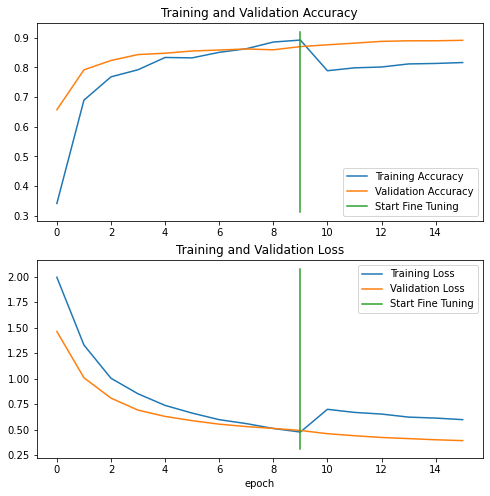

In [120]:
compare_historys(original_history=history_2, 
                 new_history=history_2_no_fine_tune, 
                 initial_epochs=10) # big overfitting

#### Comparing

In [121]:
scores = [
    ["model_2", score_2[1]],   
    ["model_2_no_fine_tune", score_2_no_fine_tune[1]],   
    ["model_2_fine_tune", score_2_fine_tune[1]],   
    ["model_2_fine_tune_full_data", score_2_fine_tune_full_data[1]],   
]

pd.DataFrame(scores, columns=["model_name", 'model_score'])

,model_name,model_score
0,model_2,0.8648
1,model_2_no_fine_tune,0.8912
2,model_2_fine_tune,0.8692
3,model_2_fine_tune_full_data,0.9056
